(1001, 6) (6, 1001)
(1001, 6) (6, 1001)


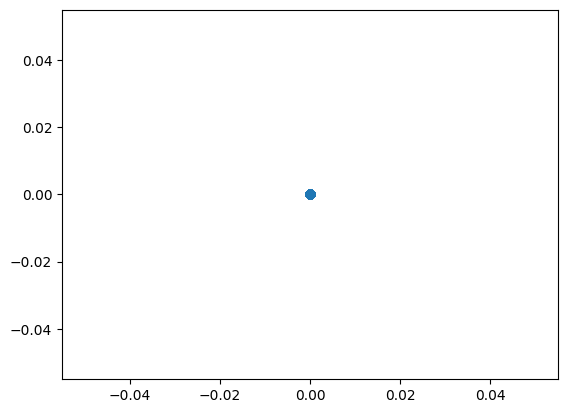

CPU times: user 9.68 ms, sys: 0 ns, total: 9.68 ms
Wall time: 9.69 ms


RuntimeError: Requested MovieWriter (ffmpeg) not available

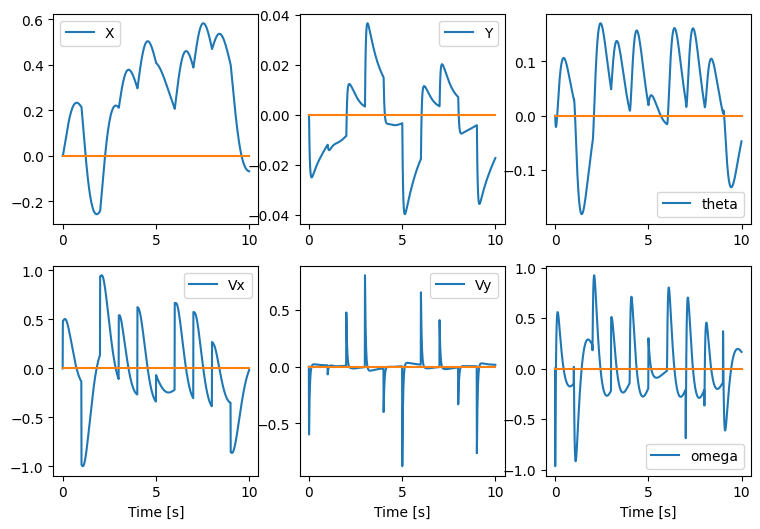

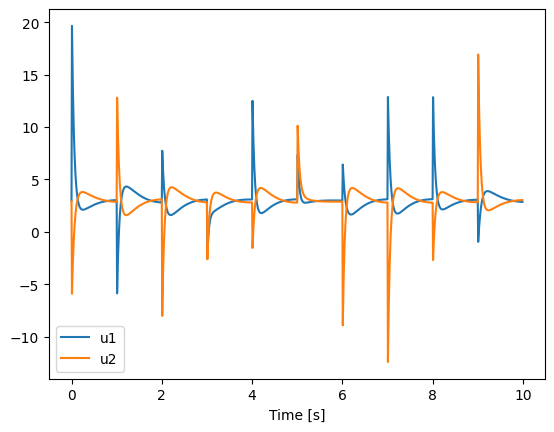

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
import quadrotor as qd
import math
import import_ipynb
import Part2_lqr_stabilization as p2



horizon_length = 1000
N = 1000
u_ = qd.MASS*qd.GRAVITY/2
z0 = np.array([1,0,0,0,0,0]).reshape([6,])
u0 = u_ * np.ones([2,1])
T = 10
middle = 500
tau = 0.6

In [2]:
import math
import numpy as np
import bisect
from scipy import interpolate
import pylab as pl

class Spline:
    """
    Cubic Spline class
    """
    def __init__(self, x, y):
        self.b, self.c, self.d, self.w = [], [], [], []
        self.x = x
        self.y = y
        self.nx = len(x)  # dimension of x
        h = np.diff(x)
        # calc coefficient c
        self.a = [iy for iy in y]
        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h)
        self.c = np.linalg.solve(A, B)
        #  print(self.c1)
        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            self.d.append((self.c[i + 1] - self.c[i]) / (3.0 * h[i]))
            tb = (self.a[i + 1] - self.a[i]) / h[i] - h[i] * \
                (self.c[i + 1] + 2.0 * self.c[i]) / 3.0
            self.b.append(tb)
    def calc(self, t):
        """
        Calc position

        if t is outside of the input x, return None

        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return result

    def calcd(self, t):
        """
        Calc first derivative
        if t is outside of the input x, return None
        """
        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return result

    def calcdd(self, t):
        """
        Calc second derivative
        """

        if t < self.x[0]:
            return None
        elif t > self.x[-1]:
            return None

        i = self.__search_index(t)
        dx = t - self.x[i]
        result = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return result

    def __search_index(self, x):
        """
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        #  print(A)
        return A

    def __calc_B(self, h):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (self.a[i + 2] - self.a[i + 1]) / \
                h[i + 1] - 3.0 * (self.a[i + 1] - self.a[i]) / h[i]
        return B


class Spline2D:
    """
    2D Cubic Spline class

    """

    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = Spline(self.s, x)
        self.sy = Spline(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = [math.sqrt(idx ** 2 + idy ** 2)
                   for (idx, idy) in zip(dx, dy)]
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """
        calc position
        """
        x = self.sx.calc(s)
        y = self.sy.calc(s)

        return x, y

    def calc_curvature(self, s):
        """
        calc curvature
        """
        dx = self.sx.calcd(s)
        ddx = self.sx.calcdd(s)
        dy = self.sy.calcd(s)
        ddy = self.sy.calcdd(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        """
        calc yaw
        """
        dx = self.sx.calcd(s)
        dy = self.sy.calcd(s)
        yaw = math.atan2(dy, dx)
        if yaw<0:
            yaw = yaw+2*math.pi
        return yaw



def calc_spline_course(x, y, ds=0.1):
    sp = Spline2D(x, y)
    s = list(np.arange(0, sp.s[-1], ds))

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return rx, ry, ryaw, rk, s


Spline 2D test


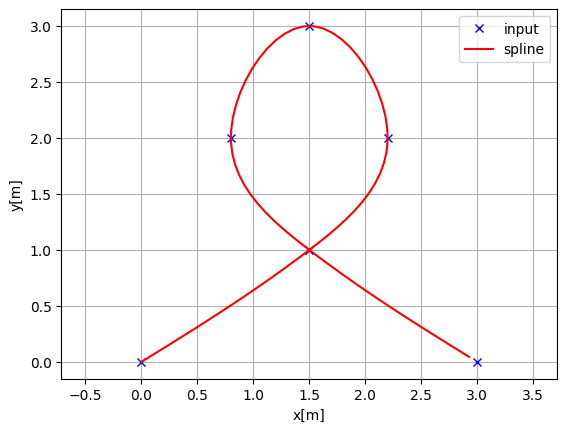

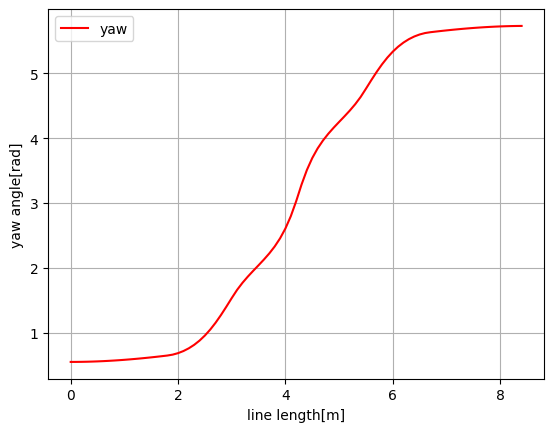

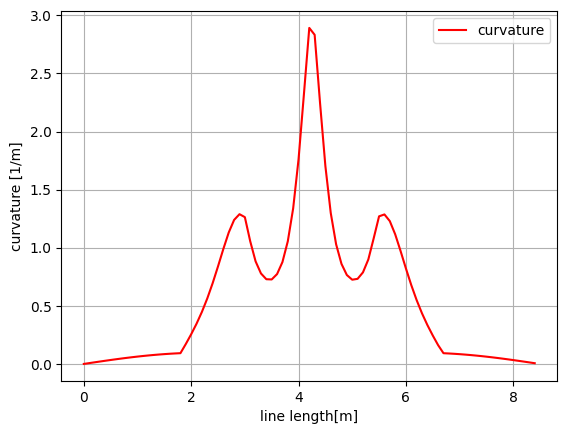

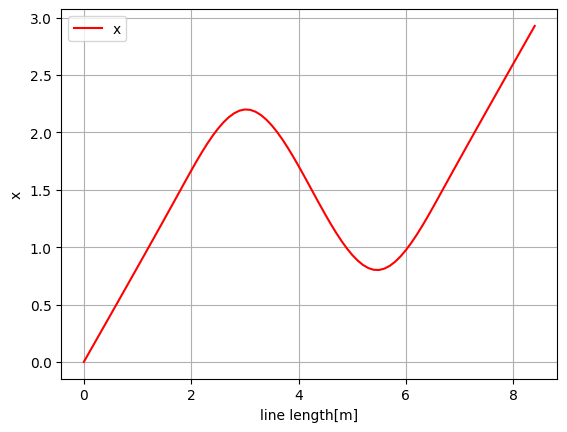

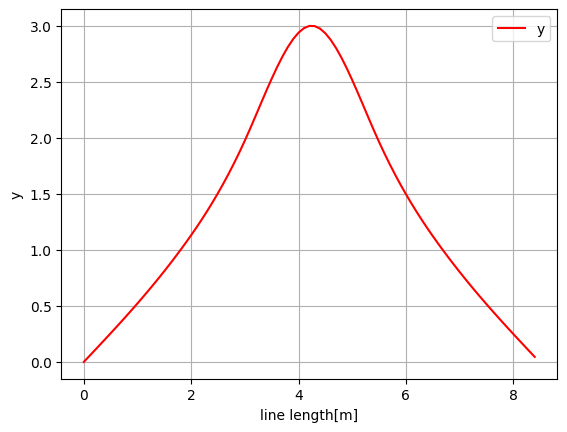

85


In [3]:

print("Spline 2D test")
import matplotlib.pyplot as plt
#     x = [0, 1.5，1.5，1.5 3, 5.0, 7.5, 3.0, -1.0]
#     y = [0, 1.2,  3, , 0.0, 5.0, -2.0]
x = [0,  1.5,  2.2,  1.5, 0.8, 1.5,  3]
y = [0,  1,     2,    3,   2, 1,   0]
ds = 0.1  # [m] distance of each intepolated points

sp = Spline2D(x, y)
s = np.arange(0, sp.s[-1], ds)
#     s = np.linespace()

rx, ry, ryaw, rk = [], [], [], []
for i_s in s:
    ix, iy = sp.calc_position(i_s)
    rx.append(ix)
    ry.append(iy)
    ryaw.append(sp.calc_yaw(i_s))
    rk.append(sp.calc_curvature(i_s))

plt.subplots(1)
plt.plot(x, y, "xb", label="input")
plt.plot(rx, ry, "-r", label="spline")
plt.grid(True)
plt.axis("equal")
plt.xlabel("x[m]")
plt.ylabel("y[m]")
plt.legend()

plt.subplots(1)
plt.plot(s, [iyaw for iyaw in ryaw], "-r", label="yaw")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("yaw angle[rad]")

plt.subplots(1)
plt.plot(s, rk, "-r", label="curvature")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("curvature [1/m]")


plt.subplots(1)
plt.plot(s, rx, "-r", label="x")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("x")


plt.subplots(1)
plt.plot(s, ry, "-r", label="y")
plt.grid(True)
plt.legend()
plt.xlabel("line length[m]")
plt.ylabel("y")

plt.show()
print(len(ryaw))




In [4]:
xopt = 2* np.asarray([0, 0.000130666345605423, 0.000261383366438624, 0.000392182026450248, 0.000523076153585229, 0.000654066784360179, 0.000785146038722314, 0.000916300559473617, 0.00104751454864321, 0.00117877243137403, 0.00131006117615360, 0.00144137229856028, 0.00157270357411312, 0.00170406048430176, 0.00183545741843200, 0.00196691865254723, 0.00209847912537678, 0.00223018503001353, 0.00236209423883567, 0.00249427657805638, 0.00262681396721010, 0.00275980043786180, 0.00289334204485447, 0.00302755668248822, 0.00316257381714917, 0.00329853414707695, 0.00343558919917327, 0.00357390087200950, 0.00371364093348666, 0.00385499048093493, 0.00399813937081034, 0.00414328562455186, 0.00429063481660148, 0.00444039945006148, 0.00459279832496559, 0.00474805590367251, 0.00490640167745064, 0.00506806953790979, 0.00523329715654860, 0.00540232537532378, 0.00557539761080819, 0.00575275927418786, 0.00593465720905268, 0.00612133914866024, 0.00631305319409655, 0.00651004731451945, 0.00671256887045106, 0.00692086416088182, 0.00713517799476070, 0.00735575328727433, 0.00758283068115811, 0.00781664819313807, 0.00805744088546945, 0.00830544056241748, 0.00856087549141708, 0.00882397014854966, 0.00909494498788675, 0.00937401623417217, 0.00966139569824381, 0.00995729061453547, 0.0102619034999455, 0.0105754320333127, 0.0108980689547022, 0.0112300019836682, 0.0115714137556395, 0.0119224817755461, 0.0122833783877954, 0.0126542707616919, 0.0130353208913908, 0.0134266856094704, 0.0138285166132147, 0.0142409605026975, 0.0146641588297734, 0.0150982481570864, 0.0155433601262275, 0.0159996215341840, 0.0164671544172449, 0.0169460761415466, 0.0174364994994648, 0.0179385328110858, 0.0184522800300108, 0.0189778408527771, 0.0195153108312075, 0.0200647814870248, 0.0206263404281009, 0.0212000714657370, 0.0217860547324031, 0.0223843667993933, 0.0229950807938876, 0.0236182665149363, 0.0242539905479182, 0.0249023163770515, 0.0255633044955681, 0.0262370125131888, 0.0269234952605716, 0.0276228048904281, 0.0283349909750369, 0.0290601005999068, 0.0297981784533725, 0.0305492669119308, 0.0313134061211516, 0.0320906340720229, 0.0328809866726140, 0.0336844978149640, 0.0345011994371258, 0.0353311215803174, 0.0361742924411536, 0.0370307384189514, 0.0379004841581213, 0.0387835525856748, 0.0396799649438965, 0.0405897408182456, 0.0415128981605658, 0.0424494533077001, 0.0433994209956169, 0.0443628143691702, 0.0453396449876270, 0.0463299228261052, 0.0473336562730778, 0.0483508521241062, 0.0493815155719750, 0.0504256501934095, 0.0514832579325594, 0.0525543390814457, 0.0536388922575650, 0.0547369143788559, 0.0558484006362324, 0.0569733444638947, 0.0581117375076270, 0.0592635695912982, 0.0604288286817764, 0.0616075008524747, 0.0627995702457407, 0.0640050190343034, 0.0652238273819908, 0.0664559734039271, 0.0677014331264172, 0.0689601804467251, 0.0702321870929454, 0.0715174225841679, 0.0728158541911266, 0.0741274468975254, 0.0754521633622197, 0.0767899638824382, 0.0781408063582137, 0.0795046462581922, 0.0808814365869824, 0.0822711278541969, 0.0836736680453380, 0.0850890025946646, 0.0865170743601792, 0.0879578236008577, 0.0894111879562453, 0.0908771024285294, 0.0923554993671947, 0.0938463084563574, 0.0953494567048697, 0.0968648684392739, 0.0983924652996835, 0.0999321662386552, 0.101483887523112, 0.103047542739368, 0.104623042801299, 0.106210295961690, 0.107809207826800, 0.109419681374148, 0.111041616973546, 0.112674912411380, 0.114319462918144, 0.115975161199203, 0.117641897468790, 0.119319559487203, 0.121008032601179, 0.122707199787398, 0.124416941699098, 0.126137136715733, 0.127867660995632, 0.129608388531595, 0.131359191209369, 0.133119938868921, 0.134890499368451, 0.136670738651045, 0.138460520813911, 0.140259708180072, 0.142068161372466, 0.143885739390320, 0.145712299687715, 0.147547698254243, 0.149391789697631, 0.151244427328237, 0.153105463245299, 0.154974748424823, 0.156852132808988, 0.158737465396956, 0.160630594336956, 0.162531367019524, 0.164439630171775, 0.166355229952580, 0.168278012048513, 0.170207821770456, 0.172144504150722, 0.174087904040572, 0.176037866207993, 0.177994235435618, 0.179956856618654, 0.181925574862684, 0.183900235581234, 0.185880684592965, 0.187866768218367, 0.189858333375839, 0.191855227677030, 0.193857299521312, 0.195864398189290, 0.197876373935207, 0.199893078078142, 0.201914363091899, 0.203940082693459, 0.205970091929899, 0.208004247263679, 0.210042406656188, 0.212084429649447, 0.214130177445895, 0.216179512986142, 0.218232301024616, 0.220288408203012, 0.222347703121474, 0.224410056407409, 0.226475340781888, 0.228543431123542, 0.230614204529891, 0.232687540376055, 0.234763320370775, 0.236841428609693, 0.238921751625843, 0.241004178437307, 0.243088600591990, 0.245174912209475, 0.247263010019925, 0.249352793400009, 0.251444164405811, 0.253537027802708, 0.255631291092207, 0.257726864535707, 0.259823661175197, 0.261921596850870, 0.264020590215660, 0.266120562746694, 0.268221438753676, 0.270323145384210, 0.272425612626063, 0.274528773306413, 0.276632563088071, 0.278736920462724, 0.280841786741224, 0.282947106040948, 0.285052825270269, 0.287158894110174, 0.289265264993084, 0.291371893078896, 0.293478736228328, 0.295585754973581, 0.297692912486414, 0.299800174543653, 0.301907509490216, 0.304014888199712, 0.306122284032672, 0.308229672792490, 0.310337032679140, 0.312444344240740, 0.314551590323036, 0.316658756016894, 0.318765828603861, 0.320872797499888, 0.322979654197295, 0.325086392205057, 0.327193006987502, 0.329299495901497, 0.331405858132229, 0.333512094627645, 0.335618208031659, 0.337724202616211, 0.339830084212266, 0.341935860139849, 0.344041539137206, 0.346147131289184, 0.348252647954929, 0.350358101694979, 0.352463506197869, 0.354568876206315, 0.356674227443095, 0.358779576536703, 0.360884940946871, 0.362990338890054, 0.365095789264975, 0.367201311578307, 0.369306925870587, 0.371412652642463, 0.373518512781336, 0.375624527488516, 0.377730718206946, 0.379837106549604, 0.381943714228641, 0.384050562985368, 0.386157674521138, 0.388265070429224, 0.390372772127763, 0.392480800793836, 0.394589177298766, 0.396697922144693, 0.398807055402511, 0.400916596651214, 0.403026564918737, 0.405136978624330, 0.407247855522554, 0.409359212648930, 0.411471066267315, 0.413583431819047, 0.415696323873918, 0.417809756083015, 0.419923741133487, 0.422038290705260, 0.424153415429772, 0.426269124850729, 0.428385427386948, 0.430502330297303, 0.432619839647813, 0.434737960280887, 0.436856695786764, 0.438976048477167, 0.441096019361174, 0.443216608123351, 0.445337813104135, 0.447459631282491, 0.449582058260844, 0.451705088252301, 0.453828714070154, 0.455952927119674, 0.458077717392183, 0.460203073461411, 0.462328982482115, 0.464455430190968, 0.466582400909682, 0.468709877550371, 0.470837841623122, 0.472966273245753, 0.475095151155747, 0.477224452724321, 0.479354153972612, 0.481484229589942, 0.483614652954142, 0.485745396153880, 0.487876430012977, 0.490007724116657, 0.492139246839694, 0.494270965376422, 0.496402845772537, 0.498534852958680, 0.500666950785717, 0.502799102061693, 0.504931268590385, 0.507063411211420, 0.509195489841881, 0.511327463519370, 0.513459290446440, 0.515590928036358, 0.517722332960136, 0.519853461194746, 0.521984268072488, 0.524114708331417, 0.526244736166786, 0.528374305283421, 0.530503368948970, 0.532631880047961, 0.534759791136582, 0.536887054498143, 0.539013622199126, 0.541139446145752, 0.543264478141021, 0.545388669942119, 0.547511973318150, 0.549634340108097, 0.551755722278963, 0.553876071984010, 0.555995341621016, 0.558113483890502, 0.560230451853831, 0.562346198991134, 0.564460679258976, 0.566573847147694, 0.568685657738355, 0.570796066759235, 0.572905030641783, 0.575012506575989, 0.577118452565077, 0.579222827479491, 0.581325591110075, 0.583426704220410, 0.585526128598226, 0.587623827105850, 0.589719763729609, 0.591813903628144, 0.593906213179574, 0.595996660027456, 0.598085213125481, 0.600171842780865, 0.602256520696373, 0.604339220010933, 0.606419915338795, 0.608498582807182, 0.610575200092391, 0.612649746454308, 0.614722202769293, 0.616792551561390, 0.618860777031837, 0.620926865086837, 0.622990803363549, 0.625052581254286, 0.627112189928875, 0.629169622355163, 0.631224873317637, 0.633277939434146, 0.635328819170692, 0.637377512854284, 0.639424022683836, 0.641468352739086, 0.643510508987543, 0.645550499289431, 0.647588333400649, 0.649624022973712, 0.651657581556697, 0.653689024590184, 0.655718369402181, 0.657745635201066, 0.659770843066521, 0.661794015938487, 0.663815178604146, 0.665834357682939, 0.667851581609635, 0.669866880615473, 0.671880286707394, 0.673891833645381, 0.675901556917931, 0.677909493715693, 0.679915682903285, 0.681920164989325, 0.683922982094717, 0.685924177919210, 0.687923797706266, 0.689921888206295, 0.691918497638258, 0.693913675649718, 0.695907473275347, 0.697899942893959, 0.699891138184098, 0.701881114078225, 0.703869926715574, 0.705857633393699, 0.707844292518776, 0.709829963554724, 0.711814706971166, 0.713798584190327, 0.715781657532884, 0.717763990162853, 0.719745646031560, 0.721726689820758, 0.723707186884942, 0.725687203192937, 0.727666805268808, 0.729646060132162, 0.731625035237895, 0.733603798415463, 0.735582417807727, 0.737560961809442, 0.739539499005455, 0.741518098108678, 0.743496827897898, 0.745475757155490, 0.747454954605108, 0.749434488849400, 0.751414428307837, 0.753394841154702, 0.755375795257308, 0.757357358114529, 0.759339596795676, 0.761322577879816, 0.763306367395566, 0.765291030761462, 0.767276632726928, 0.769263237313936, 0.771250907759406, 0.773239706458406, 0.775229694908221, 0.777220933653338, 0.779213482231416, 0.781207399120294, 0.783202741686090, 0.785199566132444, 0.787197927450983, 0.789197879373015, 0.791199474322546, 0.793202763370652, 0.795207796191245, 0.797214621018306, 0.799223284604596, 0.801233832181925, 0.803246307422993, 0.805260752404855, 0.807277207574049, 0.809295711713428, 0.811316301910712, 0.813339013528826, 0.815363880178017, 0.817390933689816, 0.819420204092844, 0.821451719590506, 0.823485506540588, 0.825521589436778, 0.827559990892140, 0.829600731624542, 0.831643830444066, 0.833689304242422, 0.835737167984339, 0.837787434700994, 0.839840115485441, 0.841895219490076, 0.843952753926112, 0.846012724065096, 0.848075133242432, 0.850139982862938, 0.852207272408403, 0.854276999447153, 0.856349159645605, 0.858423746781807, 0.860500752760930, 0.862580167632717, 0.864661979610853, 0.866746175094236, 0.868832738690133, 0.870921653239187, 0.873012899842252, 0.875106457889022, 0.877202305088420, 0.879300417500719, 0.881400769571356, 0.883503334166398, 0.885608082609616, 0.887714984721147, 0.889824008857663, 0.891935121954036, 0.894048289566434, 0.896163475916799, 0.898280643938667, 0.900399755324260, 0.902520770572815, 0.904643649040080, 0.906768348988929, 0.908894827641036, 0.911023041229540, 0.913152945052651, 0.915284493528138, 0.917417640248610, 0.919552338037571, 0.921688539006124, 0.923826194610324, 0.925965255709054, 0.928105672622396, 0.930247395190403, 0.932390372832224, 0.934534554605494, 0.936679889265928, 0.938826325327041, 0.940973811119939, 0.943122294853083, 0.945271724671978, 0.947422048718706, 0.949573215191226, 0.951725172402371, 0.953877868838487, 0.956031253217610, 0.958185274547136, 0.960339882180907, 0.962495025875632, 0.964650655846582, 0.966806722822491, 0.968963178099584, 0.971119973594673, 0.973277061897249, 0.975434396320506, 0.977591930951227, 0.979749620698464, 0.981907421340972, 0.984065289573296, 0.986223183050482, 0.988381060431338, 0.990538881420192, 0.992696606807081, 0.994854198506327, 0.997011619593439, 0.999168834340295, 1.00132580824854, 1.00348250808118, 1.00563890189229, 1.00779495905478, 1.00995065028631, 1.01210594767306, 1.01426082469158, 1.01641525622852, 1.01856921859826, 1.02072268955839, 1.02287564832306, 1.02502807557408, 1.02717995346988, 1.02933126565211, 1.03148199725013, 1.03363213488308, 1.03578166665973, 1.03793058217606, 1.04007887251041, 1.04222653021642, 1.04437354931360, 1.04651992527558, 1.04866565501602, 1.05081073687221, 1.05295517058636, 1.05509895728462, 1.05724209945370, 1.05938460091534, 1.06152646679846, 1.06366770350905, 1.06580831869790, 1.06794832122611, 1.07008772112842, 1.07222652957448, 1.07436475882794, 1.07650242220356, 1.07863953402226, 1.08077610956418, 1.08291216501988, 1.08504771743960, 1.08718278468069, 1.08931738535326, 1.09145153876416, 1.09358526485924, 1.09571858416399, 1.09785151772267, 1.09998408703598, 1.10211631399725, 1.10424822082731, 1.10637983000814, 1.10851116421523, 1.11064224624886, 1.11277309896435, 1.11490374520127, 1.11703420771182, 1.11916450908835, 1.12129467169022, 1.12342471756990, 1.12555466839866, 1.12768454539163, 1.12981436923262, 1.13194415999854, 1.13407393708369, 1.13620371912386, 1.13833352392051, 1.14046336836491, 1.14259326836255, 1.14472323875773, 1.14685329325853, 1.14898344436225, 1.15111370328133, 1.15324407986999, 1.15537458255153, 1.15750521824648, 1.15963599230165, 1.16176690842023, 1.16389796859296, 1.16602917303048, 1.16816052009701, 1.17029200624540, 1.17242362595358, 1.17455537166266, 1.17668723371661, 1.17881920030365, 1.18095125739954, 1.18308338871265, 1.18521557563105, 1.18734779717170, 1.18948002993167, 1.19161224804164, 1.19374442312165, 1.19587652423918, 1.19800851786966, 1.20014036785944, 1.20227203539133, 1.20440347895271, 1.20653465430630, 1.20866551446367, 1.21079600966147, 1.21292608734049, 1.21505569212758, 1.21718476582045, 1.21931324737544, 1.22144107289819, 1.22356817563736, 1.22569448598141, 1.22781993145831, 1.22994443673848, 1.23206792364067, 1.23419031114105, 1.23631151538532, 1.23843144970403, 1.24055002463091, 1.24266714792439, 1.24478272459215, 1.24689665691887, 1.24900884449693, 1.25111918426025, 1.25322757052112, 1.25533389501008, 1.25743804691871, 1.25953991294538, 1.26163937734394, 1.26373632197520, 1.26583062636124, 1.26792216774244, 1.27001082113726, 1.27209645940461, 1.27417895330879, 1.27625817158692, 1.27833398101886, 1.28040624649936, 1.28247483111264, 1.28453959620901, 1.28660040148366, 1.28865710505750, 1.29070956355982, 1.29275763221285, 1.29480116491802, 1.29684001434381, 1.29887403201515, 1.30090306840424, 1.30292697302256, 1.30494559451422, 1.30695878075023, 1.30896637892379, 1.31096823564640, 1.31296419704466, 1.31495410885765, 1.31693781653481, 1.31891516533406, 1.32088600042023, 1.32285016696348, 1.32480751023772, 1.32675787571883, 1.32870110918255, 1.33063705680197, 1.33256556524439, 1.33448648176755, 1.33639965431496, 1.33830493161032, 1.34020216325083, 1.34209119979933, 1.34397189287504, 1.34584409524288, 1.34770766090125, 1.34956244516804, 1.35140830476486, 1.35324509789939, 1.35507268434560, 1.35689092552192, 1.35869968456710, 1.36049882641375, 1.36228821785945, 1.36406772763527, 1.36583722647176, 1.36759658716208, 1.36934568462254, 1.37108439595011, 1.37281260047709, 1.37453017982274, 1.37623701794193, 1.37793300117060, 1.37961801826814, 1.38129196045653, 1.38295472145632, 1.38460619751929, 1.38624628745791, 1.38787489267149, 1.38949191716903, 1.39109726758881, 1.39269085321468, 1.39427258598911, 1.39584238052300, 1.39740015410225, 1.39894582669122, 1.40047932093302, 1.40200056214672, 1.40350947832163, 1.40500600010855, 1.40649006080825, 1.40796159635705, 1.40942054530989, 1.41086684882067, 1.41230045062020, 1.41372129699173, 1.41512933674436, 1.41652452118421, 1.41790680408372, 1.41927614164913, 1.42063249248621, 1.42197581756458, 1.42330608018065, 1.42462324591937, 1.42592728261502, 1.42721816031115, 1.42849585121994, 1.42976032968108, 1.43101157212046, 1.43224955700882, 1.43347426482052, 1.43468567799278, 1.43588378088545, 1.43706855974162, 1.43824000264918, 1.43939809950376, 1.44054284197299, 1.44167422346247, 1.44279223908369, 1.44389688562402, 1.44498816151894, 1.44606606682699, 1.44713060320724, 1.44818177389990, 1.44921958370994, 1.45024403899413, 1.45125514765155, 1.45225291911790, 1.45323736436355, 1.45420849589578, 1.45516632776514, 1.45611087557619, 1.45704215650271, 1.45796018930747, 1.45886499436681, 1.45975659369994, 1.46063501100312, 1.46150027168882, 1.46235240292989, 1.46319143370866, 1.46401739487116, 1.46483031918635, 1.46563024141023, 1.46641719835505, 1.46719122896326, 1.46795237438625, 1.46870067806778, 1.46943618583188, 1.47015894597500, 1.47086900936247, 1.47156642952865, 1.47225126278088, 1.47292356830676, 1.47358340828445, 1.47423084799576, 1.47486595594152, 1.47548880395895, 1.47609946734054, 1.47669802495400, 1.47728455936275, 1.47785915694652, 1.47842190802136, 1.47897290695865, 1.47951225230234, 1.48004004688390, 1.48055639793420, 1.48106141719172, 1.48155522100626, 1.48203793043748, 1.48250967134747, 1.48297057448643, 1.48342077557088, 1.48386041535327, 1.48428963968228, 1.48470859955297, 1.48511745114572, 1.48551635585317, 1.48590548029423, 1.48628499631421, 1.48665508097010, 1.48701591650026, 1.48736769027733, 1.48771059474371, 1.48804482732857, 1.48837059034559, 1.48868809087058, 1.48899754059814, 1.48929915567665, 1.48959315652089, 1.48987976760149, 1.49015921721082, 1.49043173720458, 1.49069756271886, 1.49095693186207, 1.49121008538173, 1.49145726630575, 1.49169871955841, 1.49193469155089, 1.49216542974687, 1.49239118220343, 1.49261219708792, 1.49282872217165, 1.49304100430128, 1.49324928884918, 1.49345381914431, 1.49365483588517, 1.49385257653697, 1.49404727471525, 1.49423915955861, 1.49442845509347, 1.49461537959432, 1.49480014494296, 1.49498295599116, 1.49516400993118, 1.49534349567917, 1.49552159327718, 1.49569847331982, 1.49587429641225, 1.49604921266676, 1.49622336124593, 1.49639686996096, 1.49656985493448, 1.49674242033783, 1.49691465821383, 1.49708664839670, 1.49725845854159, 1.49743014427750, 1.49760174949796, 1.49777330680493, 1.49794483812287, 1.49811635550043, 1.49828786211902, 1.49845935352834, 1.49863081913058, 1.49880224393623, 1.49897361061587, 1.49914490187413, 1.49931610317305, 1.49948720583450, 1.49965821055236, 1.49982913134745, 1.50000000000000])
yopt = -6 *np.asarray([0, 0.000199746688847343, 0.000396542544575769, 0.000589884668860458, 0.000779428403034697, 0.000964964966204006, 0.00114640102325507, 0.00132374006403882, 0.00149706548058444, 0.00166652523457137, 0.00183231801245525, 0.00199468077061834, 0.00215387757769936, 0.00231018966586013, 0.00246390660716963, 0.00261531853553851, 0.00276470933872134, 0.00291235074882762, 0.00305849726354854, 0.00320338183392178, 0.00334721225792466, 0.00349016822251143, 0.00363239893989963, 0.00377402132696483, 0.00391511867953042, 0.00405573979614040, 0.00419589850858550, 0.00433557357901747, 0.00447470892593995, 0.00461321414370772, 0.00475096528240613, 0.00488780585711963, 0.00502354805763892, 0.00515797413160145, 0.00529083791591466, 0.00542186649307795, 0.00555076195070110, 0.00567720322411698, 0.00580084800350813, 0.00592133468841186, 0.00603828437384127, 0.00615130285356197, 0.00625998262729810, 0.00636390489981140, 0.00646264156090309, 0.00655575713643520, 0.00664281070145640, 0.00672335774745046, 0.00679695199660494, 0.00686314715682637, 0.00692149861200677, 0.00697156504277930, 0.00701290997368648, 0.00704510324332897, 0.00706772239466437, 0.00708035398318772, 0.00708259480125018, 0.00707405301725984, 0.00705434922896220, 0.00702311743041798, 0.00698000589268413, 0.00692467795856262, 0.00685681275211069, 0.00677610580390868, 0.00668226959335729, 0.00657503400952740, 0.00645414673231330, 0.00631937353584505, 0.00617049851629985, 0.00600732424641581, 0.00582967185915642, 0.00563738106310030, 0.00543031009224048, 0.00520833559297073, 0.00497135245111465, 0.00471927356191707, 0.00445202954596754, 0.00416956841406353, 0.00387185518404667, 0.00355887145266009, 0.00323061492547924, 0.00288709890796320, 0.00252835176065904, 0.00215441632156903, 0.00176534929866000, 0.00136122063545626, 0.000942112852613324, 0.000508120368319185, 5.93488003138991e-05, -0.000404085747742903, -0.000882057412892242, -0.00137443130988973, -0.00188106427609220, -0.00240180562177303, -0.00293649788350201, -0.00348497757830746, -0.00404707595642320, -0.00462261975050894, -0.00521143191932085, -0.00581333238389765, -0.00642813875441832, -0.00705566704597756, -0.00769573238161679, -0.00834814968103960, -0.00901273433353212, -0.00968930285369943, -0.0103776735187204, -0.0110776669859130, -0.0117891068894907, -0.0125118204154811, -0.0132456388538613, -0.0139903981270545, -0.0147459392940138, -0.0155121090292033, -0.0162887600758680, -0.0170757516730636, -0.0178729499559948, -0.0186802283292865, -0.0194974678128872, -0.0203245573603745, -0.0211613941495032, -0.0220078838449041, -0.0228639408329063, -0.0237294884285207, -0.0246044590546804, -0.0254887943938955, -0.0263824455125336, -0.0272853729579931, -0.0281975468290857, -0.0291189468199967, -0.0300495622382354, -0.0309893919970341, -0.0319384445826970, -0.0328967379974376, -0.0338642996782832, -0.0348411663926580, -0.0358273841112915, -0.0368230078591269, -0.0378281015449340, -0.0388427377703571, -0.0398669976191523, -0.0409009704273890, -0.0419447535354125, -0.0429984520223793, -0.0440621784241952, -0.0451360524356974, -0.0462202005979343, -0.0473147559714071, -0.0484198577961443, -0.0495356511394852, -0.0506622865324566, -0.0517999195956242, -0.0529487106553058, -0.0541088243510293, -0.0552804292351198, -0.0564636973652920, -0.0576588038911224, -0.0588659266352695, -0.0600852456702987, -0.0613169428919629, -0.0625612015897789, -0.0638182060157262, -0.0650881409518850, -0.0663711912778132, -0.0676675415384512, -0.0689773755133237, -0.0703008757877946, -0.0716382233271108, -0.0729895970539552, -0.0743551734302062, -0.0757351260435872, -0.0771296251998630, -0.0785388375212228, -0.0799629255514677, -0.0814020473685975, -0.0828563562053694, -0.0843260000783790, -0.0858111214261901, -0.0873118567570168, -0.0888283363064365, -0.0903606837055909, -0.0919090156603035, -0.0934734416415223, -0.0950540635874700, -0.0966509756178573, -0.0982642637604943, -0.0998940056906085, -0.101540270483151, -0.103203118378352, -0.104882600560763, -0.106578758951990, -0.108291626017308, -0.110021224586327, -0.111767567687831, -0.113530658398922, -0.115310489708558, -0.117107044395543, -0.118920294921041, -0.120750203335610, -0.122596721200781, -0.124459789525155, -0.126339338714988, -0.128235288539186, -0.130147548108654, -0.132076015869885, -0.134020579612677, -0.135981116491842, -0.137957493062750, -0.139949565330536, -0.141957178812791, -0.143980168615515, -0.146018359522125, -0.148071566095282, -0.150139592791274, -0.152222234086701, -0.154319274617188, -0.156430489327817, -0.158555643634994, -0.160694493599423, -0.162846786109874, -0.165012259077391, -0.167190641639607, -0.169381654374814, -0.171585009525407, -0.173800411230347, -0.176027555766259, -0.178266131796771, -0.180515820629718, -0.182776296481791, -0.185047226750261, -0.187328272291330, -0.189619087704741, -0.191919321624200, -0.194228617013212, -0.196546611465909, -0.198872937512446, -0.201207222928551, -0.203549091048807, -0.205898161083237, -0.208254048436786, -0.210616365031271, -0.212984719629387, -0.215358718160351, -0.217737964046776, -0.220122058532363, -0.222510601010010, -0.224903189349930, -0.227299420227390, -0.229698889449674, -0.232101192281888, -0.234505923771220, -0.236912679069288, -0.239321053752207, -0.241730644138012, -0.244141047601079, -0.246551862883215, -0.248962690401058, -0.251373132549467, -0.253782794000586, -0.256191281998260, -0.258598206647500, -0.261003181198711, -0.263405822326385, -0.265805750401999, -0.268202589760835, -0.270595968962484, -0.272985521044778, -0.275370883770911, -0.277751699869546, -0.280127617267663, -0.282498289315974, -0.284863375006701, -0.287222539183526, -0.289575452743564, -0.291921792831187, -0.294261243023548, -0.296593493507683, -0.298918241249051, -0.301235190151408, -0.303544051207908, -0.305844542643336, -0.308136390047404, -0.310419326499026, -0.312693092681529, -0.314957436988736, -0.317212115621907, -0.319456892677484, -0.321691540225658, -0.323915838379725, -0.326129575356257, -0.328332547526099, -0.330524559456214, -0.332705423942429, -0.334874962033103, -0.337033003043812, -0.339179384563080, -0.341313952449256, -0.343436560818619, -0.345547072024804, -0.347645356629642, -0.349731293365555, -0.351804769089590, -0.353865678729259, -0.355913925220288, -0.357949419436443, -0.359972080111585, -0.361981833754089, -0.363978614553833, -0.365962364281895, -0.367933032183160, -0.369890574862017, -0.371834956161333, -0.373766147034915, -0.375684125413646, -0.377588876065525, -0.379480390449808, -0.381358666565469, -0.383223708794218, -0.385075527738290, -0.386914140053234, -0.388739568275946, -0.390551840648178, -0.392350990935760, -0.394137058243779, -0.395910086827970, -0.397670125902548, -0.399417229444744, -0.401151455996288, -0.402872868462101, -0.404581533906427, -0.406277523346684, -0.407960911545267, -0.409631776799567, -0.411290200730458, -0.412936268069500, -0.414570066445112, -0.416191686167975, -0.417801220015901, -0.419398763018419, -0.420984412241336, -0.422558266571506, -0.424120426502048, -0.425670993918267, -0.427210071884498, -0.428737764432116, -0.430254176348942, -0.431759412970277, -0.433253579971770, -0.434736783164371, -0.436209128291551, -0.437670720829026, -0.439121665787183, -0.440562067516406, -0.441992029515513, -0.443411654243483, -0.444821042934671, -0.446220295417692, -0.447609509938145, -0.448988782985360, -0.450358209123320, -0.451717880825935, -0.453067888316802, -0.454408319413628, -0.455739259377416, -0.457060790766601, -0.458372993296215, -0.459675943702248, -0.460969715611282, -0.462254379415540, -0.463530002153437, -0.464796647395724, -0.466054375137331, -0.467303241694978, -0.468543299610634, -0.469774597560893, -0.470997180272330, -0.472211088442886, -0.473416358669338, -0.474613023380888, -0.475801110778904, -0.476980644782847, -0.478151644982400, -0.479314126595805, -0.480468100434422, -0.481613572873516, -0.482750545829235, -0.483879016741804, -0.484998978564885, -0.486110419761079, -0.487213324303549, -0.488307671683706, -0.489393436924927, -0.490470590602228, -0.491539098867859, -0.492598923482735, -0.493650021853635, -0.494692347076094, -0.495725847982907, -0.496750469198136, -0.497766151196552, -0.498772830368388, -0.499770439089311, -0.500758905795490, -0.501738155063651, -0.502708107696001, -0.503668680809876, -0.504619787932008, -0.505561339097258, -0.506493240951673, -0.507415396859743, -0.508327707015681, -0.509230068558610, -0.510122375691464, -0.511004519803475, -0.511876389596068, -0.512737871212001, -0.513588848367594, -0.514429202487853, -0.515258812844347, -0.516077556695629, -0.516885309430058, -0.517681944710812, -0.518467334622936, -0.519241349822222, -0.520003859685756, -0.520754732463927, -0.521493835433738, -0.522221035053202, -0.522936197116662, -0.523639186910835, -0.524329869371390, -0.525008109239883, -0.525673771220852, -0.526326720138890, -0.526966821095510, -0.527593939625613, -0.528207941853376, -0.528808694647387, -0.529396065774819, -0.529969924054498, -0.530530139508660, -0.531076583513224, -0.531609128946427, -0.532127650335615, -0.532632024002057, -0.533122128203586, -0.533597843274920, -0.534059051765492, -0.534505638574642, -0.534937491084003, -0.535354499286943, -0.535756555914903, -0.536143556560503, -0.536515399797252, -0.536871987295761, -0.537213223936285, -0.537539017917509, -0.537849280861419, -0.538143927914169, -0.538422877842809, -0.538686053127772, -0.538933380051028, -0.539164788779782, -0.539380213445643, -0.539579592219170, -0.539762867379701, -0.539929985380404, -0.540080896908465, -0.540215556940347, -0.540333924792068, -0.540435964164428, -0.540521643183149, -0.540590934433872, -0.540643814991975, -0.540680266447191, -0.540700274922979, -0.540703831090640, -0.540690930178163, -0.540661571973787, -0.540615760824273, -0.540553505627901, -0.540474819822186, -0.540379721366334, -0.540268232718466, -0.540140380807613, -0.539996197000548, -0.539835717063459, -0.539658981118531, -0.539466033595472, -0.539256923178051, -0.539031702745694, -0.538790429310213, -0.538533163947746, -0.538259971725968, -0.537970921626676, -0.537666086463818, -0.537345542797071, -0.537009370841062, -0.536657654370341, -0.536290480620202, -0.535907940183473, -0.535510126903404, -0.535097137762749, -0.534669072769193, -0.534226034837244, -0.533768129666731, -0.533295465618035, -0.532808153584215, -0.532306306860167, -0.531790041008957, -0.531259473725507, -0.530714724697759, -0.530155915465519, -0.529583169277097, -0.528996610943953, -0.528396366693496, -0.527782564020203, -0.527155331535257, -0.526514798814849, -0.525861096247355, -0.525194354879535, -0.524514706261965, -0.523822282293870, -0.523117215067541, -0.522399636712532, -0.521669679239814, -0.520927474386080, -0.520173153458382, -0.519406847179292, -0.518628685532774, -0.517838797610960, -0.517037311462003, -0.516224353939211, -0.515400050551641, -0.514564525316329, -0.513717900612360, -0.512860297036946, -0.511991833263694, -0.511112625903252, -0.510222789366506, -0.509322435730499, -0.508411674607253, -0.507490613015666, -0.506559355256636, -0.505618002791604, -0.504666654124652, -0.503705404688334, -0.502734346733383, -0.501753569222457, -0.500763157728057, -0.499763194334781, -0.498753757546037, -0.497734922195362, -0.496706759362466, -0.495669336294147, -0.494622716330176, -0.493566958834287, -0.492502119130380, -0.491428248444030, -0.490345393849425, -0.489253598221814, -0.488152900195557, -0.487043334127870, -0.485924930068328, -0.484797713734215, -0.483661706491775, -0.482516925343436, -0.481363382921040, -0.480201087485159, -0.479030042930500, -0.477850248797466, -0.476661700289883, -0.475464388298911, -0.474258299433172, -0.473043416055080, -0.471819716323388, -0.470587174241939, -0.469345759714613, -0.468095438606436, -0.466836172810845, -0.465567920323051, -0.464290635319476, -0.463004268243207, -0.461708765895407, -0.460404071532631, -0.459090124969967, -0.457766862689933, -0.456434217957033, -0.455092120937904, -0.453740498826919, -0.452379275977191, -0.451008374036814, -0.449627712090263, -0.448237206804807, -0.446836772581811, -0.445426321712781, -0.444005764540025, -0.442575009621754, -0.441133963901495, -0.439682532881625, -0.438220620800877, -0.436748130815641, -0.435264965184866, -0.433771025458399, -0.432266212668548, -0.430750427524690, -0.429223570610719, -0.427685542585116, -0.426136244383449, -0.424575577423079, -0.423003443809846, -0.421419746546528, -0.419824389742830, -0.418217278826685, -0.416598320756625, -0.414967424234980, -0.413324499921690, -0.411669460648448, -0.410002221632962, -0.408322700693073, -0.406630818460487, -0.404926498593851, -0.403209667990950, -0.401480256999746, -0.399738199628019, -0.397983433751338, -0.396215901319130, -0.394435548558567, -0.392642326176030, -0.390836189555887, -0.389017098956334, -0.387185019702042, -0.385339922373366, -0.383481782991842, -0.381610583201761, -0.379726310447530, -0.377828958146612, -0.375918525857775, -0.373995019444439, -0.372058451232849, -0.370108840164888, -0.368146211945260, -0.366170599182842, -0.364182041525985, -0.362180585791544, -0.360166286087424, -0.358139203928454, -0.356099408345369, -0.354046975986730, -0.351981991213577, -0.349904546186647, -0.347814740945983, -0.345712683482763, -0.343598489803192, -0.341472283984316, -0.339334198221591, -0.337184372868108, -0.335022956465307, -0.332850105765094, -0.330665985743233, -0.328470769603922, -0.326264638775451, -0.324047782896875, -0.321820399795616, -0.319582695455936, -0.317334883978233, -0.315077187529109, -0.312809836282185, -0.310533068349639, -0.308247129704447, -0.305952274093348, -0.303648762940520, -0.301336865242000, -0.299016857450881, -0.296689023353331, -0.294353653935474, -0.292011047241225, -0.289661508221135, -0.287305348572341, -0.284942886569731, -0.282574446888420, -0.280200360417678, -0.277820964066430, -0.275436600560483, -0.273047618231639, -0.270654370798861, -0.268257217141667, -0.265856521065960, -0.263452651062480, -0.261045980058110, -0.258636885160238, -0.256225747394446, -0.253812951435732, -0.251398885333566, -0.248983940231006, -0.246568510078191, -0.244152991340469, -0.241737782701484, -0.239323284761502, -0.236909899731328, -0.234498031122101, -0.232088083431342, -0.229680461825565, -0.227275571819825, -0.224873818954556, -0.222475608470060, -0.220081344979035, -0.217691432137511, -0.215306272314590, -0.212926266261378, -0.210551812779519, -0.208183308389721, -0.205821147000694, -0.203465719578918, -0.201117413819645, -0.198776613819567, -0.196443699751579, -0.194119047542044, -0.191803028551015, -0.189496009255819, -0.187198350938462, -0.184910409377250, -0.182632534543100, -0.180365070300932, -0.178108354116600, -0.175862716769773, -0.173628482073196, -0.171405966598755, -0.169195479410760, -0.166997321806858, -0.164811787066992, -0.162639160210804, -0.160479717763873, -0.158333727533191, -0.156201448392252, -0.154083130076124, -0.151979012986879, -0.149889328009730, -0.147814296340229, -0.145754129322845, -0.143709028301268, -0.141679184480738, -0.139664778802691, -0.137665981832035, -0.135682953657292, -0.133715843803898, -0.131764791160877, -0.129829923921136, -0.127911359535576, -0.126009204681221, -0.124123555243539, -0.122254496313116, -0.120402102196808, -0.118566436443520, -0.116747551884673, -0.114945490689477, -0.113160284435043, -0.111391954191380, -0.109640510621301, -0.107905954095216, -0.106188274820797, -0.104487452987459, -0.102803458925576, -0.101136253280343, -0.0994857872001530, -0.0978520025393488, -0.0962348320751673, -0.0946341997386931, -0.0930500208595859, -0.0914822024243459, -0.0899306433478339, -0.0883952347577587, -0.0868758602917967, -0.0853723964070052, -0.0838847127011435, -0.0824126722455105, -0.0809561319288638, -0.0795149428119752, -0.0780889504923411, -0.0766779954785462, -0.0752819135737544, -0.0739005362677741, -0.0725336911371213, -0.0711812022524820, -0.0698428905929485, -0.0685185744663854, -0.0672080699352546, -0.0659111912472100, -0.0646277512697484, -0.0633575619281874, -0.0621004346462135, -0.0608561807882339, -0.0596246121027396, -0.0584055411658747, -0.0571987818243889, -0.0560041496371346, -0.0548214623142570, -0.0536505401532124, -0.0524912064707366, -0.0513432880298753, -0.0502066154611820, -0.0490810236771750, -0.0479663522791448, -0.0468624459553941, -0.0457691548699904, -0.0446863350411096, -0.0436138487080483, -0.0425515646859845, -0.0414993587075674, -0.0404571137504272, -0.0394247203496950, -0.0384020768946403, -0.0373890899085365, -0.0363856743108839, -0.0353917536611305, -0.0344072603830501, -0.0334321359689547, -0.0324663311629426, -0.0315098061224030, -0.0305625305570273, -0.0296244838446047, -0.0286956551229095, -0.0277760433570211, -0.0268656573814538, -0.0259645159165106, -0.0250726475583155, -0.0241900907420230, -0.0233168936777473, -0.0224531142588022, -0.0215988199418945, -0.0207540875989643, -0.0199190033404225, -0.0190936623095945, -0.0182781684482377, -0.0174726342330655, -0.0166771803832740, -0.0158919355391373, -0.0151170359118060, -0.0143526249045176, -0.0135988527055015, -0.0128558758529375, -0.0121238567724089, -0.0114029632873699, -0.0106933681032316, -0.00999524826575511, -0.00930878459453052, -0.00863416109240432, -0.00797156433181276, -0.00732118281906781, -0.00668320633773640, -0.00605782527234757, -0.00544522991375751, -0.00484560974759820, -0.00425915272733219, -0.00368604453353254, -0.00312646782110461, -0.00258060145626276, -0.00204861974517225, -0.00153069165626218, -0.00102698003831109, -0.000537640836500206, -6.28223087224208e-05, 0.000397335755474556, 0.000842702810843903, 0.00127315832474105, 0.00168859253513502, 0.00208890719561376, 0.00247401630459231, 0.00284384681586043, 0.00319833932754006, 0.00353744874646068, 0.00386114492490554, 0.00416941326663134, 0.00446225529902208, 0.00473968920820184, 0.00500175033390487, 0.00524849162088262, 0.00547998402361873, 0.00569631686112427, 0.00589759811859809, 0.00608395469276041, 0.00625553257770580, 0.00641249698816942, 0.00655503241716722, 0.00668334262504730, 0.00679765055708797, 0.00689819818688792, 0.00698524628292698, 0.00705907409582407, 0.00711997896399063, 0.00716827583556847, 0.00720429670475622, 0.00722838996086646, 0.00724091964871937, 0.00724226463926880, 0.00723281770967458, 0.00721298453238249, 0.00718318257315138, 0.00714383989837735, 0.00709539389250989, 0.00703828988683454, 0.00697297970141445, 0.00689992010253934, 0.00681957117862829, 0.00673239463817227, 0.00663885203398774, 0.00653940291878375, 0.00643450293782558, 0.00632460186530887, 0.00621014159194286, 0.00609155407218068, 0.00596925924053247, 0.00584366290745429, 0.00571515464642658, 0.00558410568502085, 0.00545086681400726, 0.00531576632987935, 0.00517910802756989, 0.00504116926160578, 0.00490219909550285, 0.00476241656083750, 0.00462200904915290, 0.00448113086166830, 0.00433990194366180, 0.00419840683239556, 0.00405669384954969, 0.00391477457133150, 0.00377262361173401, 0.00363017875683527, 0.00348734149056236, 0.00334397795499530, 0.00319992039105960, 0.00305496910835785, 0.00290889503592331, 0.00276144290884814, 0.00261233514904848, 0.00246127650188536, 0.00230795949396660, 0.00215207078121789, 0.00199329846023496, 0.00183134042001900, 0.00166591381545959, 0.00149676574836975, 0.00132368524650048, 0.00114651663577546, 0.000965174405994504, 0.000779659675464735, 0.000590078365436573, 0.000396661200854901, 0.000199785659790486, 0])
thetaopt = np.asarray([0, 0.000430628142579731, 0.000446500257470059, 3.16920614042876e-05, -0.000825235989492590, -0.00213164259050188, -0.00389118503193591, -0.00610417533190879, -0.00876791415176571, -0.0118770035462204, -0.0154236395600949, -0.0193978856446736, -0.0237879278290409, -0.0285803125453334, -0.0337601679715747, -0.0393114097216368, -0.0452169316788600, -0.0514587827379326, -0.0580183301887448, -0.0648764104460780, -0.0720134678001159, -0.0794096818348667, -0.0870450841346207, -0.0948996648725180, -0.102953469850134, -0.111186688532688, -0.119579733601022, -0.128113312518831, -0.136768491591764, -0.145526752973948, -0.154370045057077, -0.163280826657648, -0.172242105398948, -0.181237470666173, -0.190251121495480, -0.199267889740809, -0.208273258846029, -0.217253378534196, -0.226195075710638, -0.235085861861959, -0.243913937219098, -0.252668191939055, -0.261338204546966, -0.269914237867726, -0.278387232664401, -0.286748799189161, -0.294991206841406, -0.303107372117163, -0.311090845023653, -0.318935794123146, -0.326636990360856, -0.334189789822680, -0.341590115559926, -0.348834438609970, -0.355919758333894, -0.362843582184562, -0.369603905011411, -0.376199188001296, -0.382628337348118, -0.388890682737689, -0.394985955728215, -0.400914268101073, -0.406676090251031, -0.412272229679886, -0.417703809652449, -0.422972248069123, -0.428079236604772, -0.433026720159300, -0.437816876661287, -0.442452097262138, -0.446934966954562, -0.451268245645675, -0.455454849711756, -0.459497834058540, -0.463400374708000, -0.467165751929750, -0.470797333932613, -0.474298561129374, -0.477672930985429, -0.480923983459828, -0.484055287045166, -0.487070425410813, -0.489972984652187, -0.492766541147061, -0.495454650018328, -0.498040834201149, -0.500528574111084, -0.502921297908462, -0.505222372353154, -0.507435094242755, -0.509562682426209, -0.511608270384012, -0.513574899365234, -0.515465512070904, -0.517282946872542, -0.519029932554054, -0.520709083564597, -0.522322895769554, -0.523873742686314, -0.525363872191133, -0.526795403683080, -0.528170325690724, -0.529490493907025, -0.530757629637685, -0.531973318648070, -0.533139010393691, -0.534256017619180, -0.535325516310652, -0.536348545986323, -0.537326010310312, -0.538258678014591, -0.539147184114128, -0.539992031400390, -0.540793592198504, -0.541552110373509, -0.542267703571342, -0.542940365680353, -0.543569969499403, -0.544156269598777, -0.544698905360424, -0.545197404184283, -0.545651184847693, -0.546059561005223, -0.546421744816472, -0.546736850689767, -0.547003899129910, -0.547221820678513, -0.547389459935717, -0.547505579652460, -0.547568864882757, -0.547577927185788, -0.547531308867950, -0.547427487255320, -0.547264878987361, -0.547041844322998, -0.546756691450548, -0.546407680793334, -0.545993029303124, -0.545510914733882, -0.544959479888657, -0.544336836832757, -0.543641071066669, -0.542870245652541, -0.542022405288322, -0.541095580324002, -0.540087790714690, -0.538997049905576, -0.537821368644120, -0.536558758715126, -0.535207236594608, -0.533764827018702, -0.532229566464089, -0.530599506536719, -0.528872717265867, -0.527047290300824, -0.525121342007764, -0.523093016464607, -0.520960488351899, -0.518721965738002, -0.516375692757093, -0.513919952178693, -0.511353067867674, -0.508673407133894, -0.505879382970799, -0.502969456182545, -0.499942137399371, -0.496795988981124, -0.493529626809036, -0.490141721965998, -0.486631002305735, -0.482996253911470, -0.479236322444770, -0.475350114385436, -0.471336598163437, -0.467194805183977, -0.462923830746963, -0.458522834862209, -0.453991042961842, -0.449327746511478, -0.444532303521833, -0.439604138962519, -0.434542745079859, -0.429347681620659, -0.424018575963916, -0.418555123162533, -0.412957085897160, -0.407224294344367, -0.401356645961361, -0.395354105189564, -0.389216703079368, -0.382944536838438, -0.376537769305987, -0.369996628355438, -0.363321406227955, -0.356512458799315, -0.349570204782636, -0.342495124869464, -0.335287760811763, -0.327948714447324, -0.320478646671139, -0.312878276355282, -0.305148379219813, -0.297289786657239, -0.289303384513052, -0.281190111824839, -0.272950959522444, -0.264586969091666, -0.256099231203929, -0.247488884314345, -0.238757113230575, -0.229905147654850, -0.220934260701498, -0.211845767392276, -0.202641023131787, -0.193321422165213, -0.183888396020566, -0.174343411937616, -0.164687971285618, -0.154923607971909, -0.145051886843418, -0.135074402083072, -0.124992775603040, -0.114808655436722, -0.104523714131322, -0.0941396471428139, -0.0836581712350503, -0.0730810228847125, -0.0624099566937625, -0.0516467438109912, -0.0407931703642167, -0.0298510359046292, -0.0188221518647298, -0.00770834003125896, 0.00348856896554643, 0.0147667371450746, 0.0261243206506015, 0.0375594712035133, 0.0490703375363504, 0.0606550668035962, 0.0723118059691806, 0.0840387031697183, 0.0958339090525634, 0.107695578087791, 0.119621869853300, 0.131610950292242, 0.143660992942073, 0.155770180134527, 0.167936704165907, 0.180158768437100, 0.192434588562785, 0.204762393449350, 0.217140426341081, 0.229566945834210, 0.242040226858502, 0.254558561626037, 0.267120260546954, 0.279723653111902, 0.292367088741051, 0.305048937599483, 0.317767591378891, 0.330521464045498, 0.343308992554180, 0.356128637528801, 0.368978883908792, 0.381858241562066, 0.394765245864375, 0.407698458245243, 0.420656466700666, 0.433637886272775, 0.446641359496690, 0.459665556814848, 0.472709176959073, 0.485770947300715, 0.498849624169204, 0.511943993139379, 0.525052869287975, 0.538175097419697, 0.551309552263304, 0.564455138638142, 0.577610791591634, 0.590775476508180, 0.603948189190000, 0.617127955910431, 0.630313833440235, 0.643504909047439, 0.656700300471319, 0.669899155871070, 0.683100653749777, 0.696304002854281, 0.709508442051549, 0.722713240182186, 0.735917695891693, 0.749121137440134, 0.762322922490838, 0.775522437878790, 0.788719099359369, 0.801912351338087, 0.815101666581988, 0.828286545913375, 0.841466517886525, 0.854641138448074, 0.867809990581705, 0.880972683937853, 0.894128854449042, 0.907278163931563, 0.920420299674121, 0.933554974014122, 0.946681923902268, 0.959800910456079, 0.972911718503032, 0.986014156113908, 0.999108054127029, 1.01219326566398, 1.02526966563748, 1.03833715025194, 1.05139563649741, 1.06444506163747, 1.07748538269164, 1.09051657591291, 1.10353863626098, 1.11655157687175, 1.12955542852365, 1.14255023910126, 1.15553607305691, 1.16851301087063, 1.18148114850904, 1.19444059688374, 1.20739148130947, 1.22033394096287, 1.23326812834189, 1.24619420872671, 1.25911235964228, 1.27202277032314, 1.28492564118081, 1.29782118327421, 1.31070961778348, 1.32359117548759, 1.33646609624610, 1.34933462848548, 1.36219702869018, 1.37505356089898, 1.38790449620681, 1.40075011227231, 1.41359069283159, 1.42642652721826, 1.43925790989013, 1.45208513996283, 1.46490852075051, 1.47772835931389, 1.49054496601592, 1.50335865408518, 1.51616973918722, 1.52897853900409, 1.54178537282213, 1.55459056112824, 1.56739442521472, 1.58019728679290, 1.59299946761556, 1.60580128910833, 1.61860307201014, 1.63140513602285, 1.64420779947003, 1.65701137896508, 1.66981618908866, 1.68262254207550, 1.69543074751065, 1.70824111203514, 1.72105393906115, 1.73386952849657, 1.74668817647910, 1.75951017511975, 1.77233581225580, 1.78516537121318, 1.79799913057815, 1.81083736397843, 1.82368033987347, 1.83652832135403, 1.84938156595093, 1.86224032545277, 1.87510484573281, 1.88797536658466, 1.90085212156681, 1.91373533785599, 1.92662523610904, 1.93952203033341, 1.95242592776603, 1.96533712876049, 1.97825582668242, 1.99118220781291, 2.00411645125987, 2.01705872887722, 2.03000920519169, 2.04296803733717, 2.05593537499648, 2.06891136035037, 2.08189612803355, 2.09488980509779, 2.10789251098169, 2.12090435748724, 2.13392544876274, 2.14695588129212, 2.15999574389050, 2.17304511770567, 2.18610407622549, 2.19917268529106, 2.21225100311536, 2.22533908030733, 2.23843695990118, 2.25154467739083, 2.26466226076920, 2.27778973057230, 2.29092709992801, 2.30407437460922, 2.31723155309132, 2.33039862661384, 2.34357557924616, 2.35676238795699, 2.36995902268759, 2.38316544642861, 2.39638161530028, 2.40960747863595, 2.42284297906873, 2.43608805262115, 2.44934262879775, 2.46260663068031, 2.47587997502581, 2.48916257236679, 2.50245432711416, 2.51575513766218, 2.52906489649561, 2.54238349029891, 2.55571080006727, 2.56904670121950, 2.58239106371259, 2.59574375215783, 2.60910462593850, 2.62247353932889, 2.63585034161461, 2.64923487721420, 2.66262698580177, 2.67602650243079, 2.68943325765870, 2.70284707767260, 2.71626778441558, 2.72969519571393, 2.74312912540495, 2.75656938346540, 2.77001577614054, 2.78346810607361, 2.79692617243583, 2.81038977105672, 2.82385869455480, 2.83733273246861, 2.85081167138796, 2.86429529508541, 2.87778338464788, 2.89127571860854, 2.90477207307863, 2.91827222187948, 2.93177593667461, 2.94528298710174, 2.95879314090489, 2.97230616406649, 2.98582182093935, 2.99933987437868, 3.01286008587400, 3.02638221568095, 3.03990602295304, 3.05343126587328, 3.06695770178569, 3.08048508732669, 3.09401317855634, 3.10754173108950, 3.12107050022674, 3.13459924108523, 3.14812770872938, 3.16165565830134, 3.17518284515139, 3.18870902496808, 3.20223395390830, 3.21575738872708, 3.22927908690733, 3.24279880678925, 3.25631630769973, 3.26983135008146, 3.28334369562182, 3.29685310738170, 3.31035934992401, 3.32386218944198, 3.33736139388735, 3.35085673309819, 3.36434797892658, 3.37783490536601, 3.39131728867847, 3.40479490752138, 3.41826754307408, 3.43173497916407, 3.44519700239296, 3.45865340226195, 3.47210397129702, 3.48554850517368, 3.49898680284124, 3.51241866664665, 3.52584390245783, 3.53926231978644, 3.55267373191005, 3.56607795599373, 3.57947481321095, 3.59286412886371, 3.60624573250200, 3.61961945804236, 3.63298514388557, 3.64634263303350, 3.65969177320477, 3.67303241694955, 3.68636442176310, 3.69968765019813, 3.71300196997596, 3.72630725409619, 3.73960338094505, 3.75289023440218, 3.76616770394581, 3.77943568475626, 3.79269407781764, 3.80594279001765, 3.81918173424543, 3.83241082948731, 3.84563000092036, 3.85883918000366, 3.87203830456716, 3.88522731889799, 3.89840617382418, 3.91157482679559, 3.92473324196197, 3.93788139024801, 3.95101924942529, 3.96414680418091, 3.97726404618283, 3.99037097414161, 4.00346759386850, 4.01655391832977, 4.02962996769709, 4.04269576939384, 4.05575135813721, 4.06879677597591, 4.08183207232345, 4.09485730398667, 4.10787253518957, 4.12087783759216, 4.13387329030420, 4.14685897989372, 4.15983500039016, 4.17280145328197, 4.18575844750853, 4.19870609944621, 4.21164453288845, 4.22457387901980, 4.23749427638354, 4.25040587084299, 4.26330881553625, 4.27620327082414, 4.28908940423143, 4.30196739038099, 4.31483741092082, 4.32769965444392, 4.34055431640063, 4.35340159900360, 4.36624171112502, 4.37907486818610, 4.39190129203877, 4.40472121083925, 4.41753485891358, 4.43034247661498, 4.44314431017282, 4.45594061153330, 4.46873163819145, 4.48151765301475, 4.49429892405797, 4.50707572436928, 4.51984833178762, 4.53261702873111, 4.54538210197667, 4.55814384243051, 4.57090254488977, 4.58365850779500, 4.59641203297365, 4.60916342537445, 4.62191299279265, 4.63466104558625, 4.64740789638310, 4.66015385977891, 4.67289925202621, 4.68564439071439, 4.69838959444065, 4.71113518247208, 4.72388147439899, 4.73662878977925, 4.74937744777418, 4.76212776677566, 4.77488006402487, 4.78763465522257, 4.80039185413119, 4.81315197216882, 4.82591531799518, 4.83868219708983, 4.85145291132285, 4.86422775851787, 4.87700703200810, 4.88979102018517, 4.90258000604123, 4.91537426670445, 4.92817407296822, 4.94097968881423, 4.95379137092986, 4.96660936821990, 4.97943392131316, 4.99226526206416, 5.00510361305022, 5.01794918706423, 5.03080218660365, 5.04366280335578, 5.05653121768005, 5.06940759808733, 5.08229210071696, 5.09518486881174, 5.10808603219134, 5.12099570672463, 5.13391399380122, 5.14684097980283, 5.15977673557491, 5.17272131589884, 5.18567475896551, 5.19863708585044, 5.21160829999121, 5.22458838666753, 5.23757731248473, 5.25057502486084, 5.26358145151825, 5.27659649998014, 5.28962005707248, 5.30265198843204, 5.31569213802112, 5.32874032764951, 5.34179635650431, 5.35486000068821, 5.36793101276684, 5.38100912132584, 5.39409403053832, 5.40718541974316, 5.42028294303505, 5.43338622886667, 5.44649487966384, 5.45960847145414, 5.47272655350983, 5.48584864800544, 5.49897424969104, 5.51210282558154, 5.52523381466285, 5.53836662761543, 5.55150064655608, 5.56463522479828, 5.57776968663217, 5.59090332712433, 5.60403541193845, 5.61716517717713, 5.63029182924579, 5.64341454473894, 5.65653247034976, 5.66964472280338, 5.68275038881454, 5.69584852507012, 5.70893815823725, 5.72201828499747, 5.73508787210740, 5.74814585648671, 5.76119114533356, 5.77422261626832, 5.78723911750585, 5.80023946805688, 5.81322245795896, 5.82618684853731, 5.83913137269610, 5.85205473524043, 5.86495561322938, 5.87783265636063, 5.89068448738667, 5.90350970256314, 5.91630687212945, 5.92907454082186, 5.94181122841935, 5.95451543032233, 5.96718561816441, 5.97982024045730, 5.99241772326884, 6.00497647093446, 6.01749486680166, 6.02997127400796, 6.04240403629179, 6.05479147883656, 6.06713190914766, 6.07942361796207, 6.09166488019058, 6.10385395589223, 6.11598909128061, 6.12806851976188, 6.14009046300388, 6.15205313203597, 6.16395472837929, 6.17579344520662, 6.18756746853142, 6.19927497842555, 6.21091415026470, 6.22248315600105, 6.23398016546239, 6.24540334767666, 6.25675087222134, 6.26802091059655, 6.27921163762101, 6.29032123284975, 6.30134788201264, 6.31228977847242, 6.32314512470128, 6.33391213377458, 6.34458903088049, 6.35517405484432, 6.36566545966600, 6.37606151606935, 6.38636051306173, 6.39656075950241, 6.40666058567810, 6.41665834488415, 6.42655241500945, 6.43634120012363, 6.44602313206447, 6.45559667202396, 6.46506031213084, 6.47441257702803, 6.48365202544267, 6.49277725174694, 6.50178688750757, 6.51067960302188, 6.51945410883833, 6.52810915725923, 6.53664354382358, 6.54505610876768, 6.55334573846118, 6.56151136681647, 6.56955197666877, 6.57746660112477, 6.58525432487735, 6.59291428548391, 6.60044567460593, 6.60784773920730, 6.61511978270887, 6.62226116609682, 6.62927130898228, 6.63614969060974, 6.64289585081172, 6.64950939090716, 6.65598997454108, 6.66233732846298, 6.66855124324145, 6.67463157391259, 6.68057824055970, 6.68639122882185, 6.69207059032892, 6.69761644306066, 6.70302897162757, 6.70830842747107, 6.71345512898091, 6.71846946152748, 6.72335187740684, 6.72810289569654, 6.73272310201988, 6.73721314821698, 6.74157375192049, 6.74580569603426, 6.74990982811322, 6.75388705964278, 6.75773836521624, 6.76146478160878, 6.76506740674663, 6.76854739857026, 6.77190597379046, 6.77514440653641, 6.77826402689468, 6.78126621933880, 6.78415242104854, 6.78692412011863, 6.78958285365672, 6.79213020577041, 6.79456780544349, 6.79689732430168, 6.79912047426830, 6.80123900511055, 6.80325470187727, 6.80516938222918, 6.80698489366294, 6.80870311063047, 6.81032593155536, 6.81185527574815, 6.81329308022282, 6.81464129641690, 6.81590188681787, 6.81707682149876, 6.81816807456632, 6.81917762052508, 6.82010743056114, 6.82095946874983, 6.82173568819137, 6.82243802707939, 6.82306840470711, 6.82362871741643, 6.82412083449552, 6.82454659403076, 6.82490779871916, 6.82520621164787, 6.82544355204741, 6.82562149102599, 6.82574164729228, 6.82580558287440, 6.82581479884342, 6.82577073104970, 6.82567474588095, 6.82552813605124, 6.82533211643024, 6.82508781992274, 6.82479629340842, 6.82445849375245, 6.82407528389772, 6.82364742904971, 6.82317559296563, 6.82266033435943, 6.82210210343475, 6.82150123855830, 6.82085796308609, 6.82017238235559, 6.81944448085702, 6.81867411959696, 6.81786103366834, 6.81700483004036, 6.81610498558265, 6.81516084533792, 6.81417162105759, 6.81313639001502, 6.81205409411110, 6.81092353928711, 6.80974339525971, 6.80851219559326, 6.80722833812425, 6.80589008575310, 6.80449556761817, 6.80304278066702, 6.80152959163962, 6.79995373947828, 6.79831283817866, 6.79660438009616, 6.79482573972172, 6.79297417794041, 6.79104684678632, 6.78904079470633, 6.78695297234521, 6.78478023886367, 6.78251936880049, 6.78016705948923, 6.77771993903906, 6.77517457488864, 6.77252748294077, 6.76977513728497, 6.76691398051357, 6.76394043463607, 6.76085091259509, 6.75764183038602, 6.75430961978069, 6.75085074165428, 6.74726169991252, 6.74353905601471, 6.73967944408614, 6.73567958661131, 6.73153631069719, 6.72724656489357, 6.72280743655490, 6.71821616972542, 6.71347018352680, 6.70856709102417, 6.70350471854377, 6.69828112541179, 6.69289462408067, 6.68734380060543, 6.68162753542879, 6.67574502442965, 6.66969580018527, 6.66347975339318, 6.65709715439372, 6.65054867472951, 6.64383540867283, 6.63695889464623, 6.62992113645627, 6.62272462425398, 6.61537235512964, 6.60786785324249, 6.60021518937957, 6.59241899983026, 6.58448450445570, 6.57641752382461, 6.56822449527843, 6.55991248778024, 6.55148921539333, 6.54296304922525, 6.53434302766406, 6.52563886472299, 6.51686095629919, 6.50802038414144, 6.49912891730978, 6.49019901089853, 6.48124380178151, 6.47227710112525, 6.46331338340275, 6.45436777162620, 6.44545601850266, 6.43659448320146, 6.42780010340649, 6.41909036231032, 6.41048325019002, 6.40199722018712, 6.39365113789600, 6.38546422434580, 6.37745599194192, 6.36964617291215, 6.36205463978211, 6.35470131738237, 6.34760608586718, 6.34078867420147, 6.33426854354818, 6.32806475996321, 6.32219585577910, 6.31667967903164, 6.31153323025578, 6.30677248594850, 6.30241220796625, 6.29846573809411, 6.29494477699148, 6.29185914668664, 6.28921653575812, 6.28702222630573, 6.28527880177781, 6.28398583468345, 6.28313955318000, 6.28273248548567, 6.28275308102593, 6.28318530717959])
x_bar = np.zeros([qd.NUMBER_STATES,horizon_length+1])
for i in range(951):
    x_bar[0,i+50] = xopt[i]
    x_bar[2,i+50] = yopt[i]
    x_bar[4,i+50] = thetaopt[i]
state_desired = x_bar

NameError: name 'horizon_length' is not defined

In [5]:
from __future__ import print_function




import numpy as np
import matplotlib.pyplot as plt
import math



horizon_length = 1000
N = 1000
u_ = qd.MASS * qd.GRAVITY/2
z0 = np.array([1,0,0,0,0,0]).reshape([6,])
u0 = u_ * np.ones([2,1])
o = (2*math.pi/10)/6
r = 1
T = 10
middle = 500


In [6]:
pi = math.pi

In [7]:
ref_traj = state_desired.T
z0 = state_desired[:,0]
u_init = [(qd.MASS * qd.GRAVITY / 2) * np.ones([2]) for _ in range(horizon_length)]
print(ref_traj.shape,state_desired.shape)
import solver
try:
    import jax.numpy as np
except ImportError:
    import numpy as np

class iLQR_Track_Controller:
    def __init__(self,R,dt,use_autograd = False):
        self.aux = None
        self.R_ = R
        self.dt_ = dt

        #desired functions for plant dynamics and cost
        self.plant_dyn_ = None
        self.plant_dyn_dx_ = None
        self.plant_dyn_du_ = None

        self.cost_ = None
        self.cost_dx_ = None
        self.cost_du_ = None
        self.cost_dxx_ = None
        self.cost_duu_ = None
        self.cost_dux_ = None

        self.ilqr_ = None

        self.use_autograd=use_autograd
        return

    def build_iLQR_tracking(self,ref_pnts, weight_mats,obj):
        #obj must have next_state,  get_linearization
        self.obj = obj
        #figure out dimension
        self.T_ = len(ref_pnts)# leave the last point alone


        self.ref_array = np.copy(ref_pnts)
        self.weight_array = [mat for mat in weight_mats]
        #clone weight mats if there are not enough weight mats
        for i in range(self.T_ - len(self.weight_array)):
            self.weight_array.append(self.weight_array[-1])


        def tmp_cost_func(x, u, t, aux):
            err = x - self.ref_array[t]
            cost = np.dot(np.dot(err, self.weight_array[t]), err) + np.sum(u**2) * self.R_
            return cost

        self.cost_ = tmp_cost_func
        self.ilqr_ = solver.Solver(T=self.T_ - 1, plant_dyn=self.plant_dyn_, cost=self.cost_,
                                   use_autograd=self.use_autograd)
        if not self.use_autograd:
            self.plant_dyn = lambda x, u, t, aux:qd.get_next_state(x,u)
            self.plant_dyn_du_ = lambda x, u, t, aux: p2.get_linearization(x, u)[0]
            self.plant_dyn_dx_ = lambda x, u, t, aux: p2.get_linearization(x, u)[1]
            def tmp_cost_func_dx(x, u, t, aux):
                err = x - self.ref_array[t]
                grad = np.concatenate([2 * err.dot(self.weight_array[t])])
                return grad

            self.cost_dx_ = tmp_cost_func_dx

            self.cost_du_ = lambda x, u, t, aux: 2 * self.R_ * u

            def tmp_cost_func_dxx(x, u, t, aux):
                hessian = np.zeros((qd.NUMBER_STATES,qd.NUMBER_STATES))
                hessian = 2 * self.weight_array[t]
                return hessian

            self.cost_dxx_ = tmp_cost_func_dxx

            self.cost_duu_ = lambda x, u, t, aux: 2 * self.R_ * np.eye(qd.NUMBER_CONTROLS)
            self.cost_dux_ = lambda x, u, t, aux: np.zeros((qd.NUMBER_CONTROLS,qd.NUMBER_STATES))

            # build an iLQR solver based on given functions...
            self.ilqr_.plant_dyn = self.plant_dyn
            self.ilqr_.plant_dyn_dx = self.plant_dyn_dx_
            self.ilqr_.plant_dyn_du = self.plant_dyn_du_
            self.ilqr_.cost_dx = self.cost_dx_
            self.ilqr_.cost_du = self.cost_du_
            self.ilqr_.cost_dxx = self.cost_dxx_
            self.ilqr_.cost_duu = self.cost_duu_
            self.ilqr_.cost_dux = self.cost_dux_
        return

    def synthesize_trajectory(self,x0, u_array=None, n_itrs=50, tol=1e-6, verbose=True):
        if self.ilqr_ is None:
            print('No iLQR solver has been prepared.')
            return None
        #initialization doesn't matter as global optimality can be guaranteed?
        if u_array is None:
            u_init = [np.zeros(qd.NUMBER_CONTROLS) for i in range(self.T_-1)]
        else:
            u_init = u_array
        x_init = np.zeros(qd.NUMBER_STATES)
        x_init[:len(x0)] = x0

        # res = self.lqr_.ilqr_iterate(x_init, u_init, n_itrs=n_itrs, tol=tol, verbose=verbose)
        res_dict = self.ilqr_.LQR_solve(x_init, u_init)
        x_star = res_dict['x_array_star']
        Ks = res_dict['K_array_opt']
        ks = res_dict['k_array_opt']
        x_array_new, u_array_new = self.apply_control(x_star, u_init, ks, Ks,alpha=1)
        return x_array_new[:, 0:qd.NUMBER_CONTROLS]

    def get_rule(self,x0, u_array=None, n_itrs=50, tol=1e-6, verbose=True):
        if self.ilqr_ is None:
            print('No iLQR solver has been prepared.')
            return None
        #initialization doesn't matter as global optimality can be guaranteed?
        if u_array is None:
            u_init = [np.zeros(qd.NUMBER_CONTROLS) for i in range(self.T_-1)]
        else:
            u_init = u_array
        x_init = np.zeros(qd.NUMBER_STATES)
        x_init[:len(x0)] = x0

        # res = self.lqr_.ilqr_iterate(x_init, u_init, n_itrs=n_itrs, tol=tol, verbose=verbose)
        res_dict = self.ilqr_.iLQR_iteration(x_init, u_init,n_itrs)
        # x_star = res_dict['x_array_star']
        # Ks = res_dict['K_array_opt']
        # ks = res_dict['k_array_opt']
        # xs = res_dict['x_array_opt']
        # us = res_dict['u_array_opt']
        return res_dict

    def controller(self,u,x,k_array,K_array):
        pass

    def apply_control(self, x_array, u_array, k_array, K_array,alpha=1) :
        x_new_array = [None] * len(x_array)
        u_new_array = [None] * len(u_array)
        x_new_array[0] = x_array[0]
        for t in range(self.T_ -1 ):
            u_new_array[t] = u_array[t] + alpha * (k_array[t] + K_array[t].dot(x_new_array[t]-x_array[t]))
            x_new_array[t+1] = qd.get_next_state(x_new_array[t], u_new_array[t])
        return np.array(x_new_array), np.array(u_new_array)

(1001, 6) (6, 1001)


In [8]:
weight_mats = [np.diag([2 ,1 ,1, 1, 2, 1])]
ilqr_traj_ctrl = iLQR_Track_Controller(R=.001, dt=0.01)
ilqr_traj_ctrl.build_iLQR_tracking(ref_traj, weight_mats, qd)
x0 = ref_traj[0]
res = ilqr_traj_ctrl.get_rule(x0, u_init,n_itrs = 150, tol = 1)
z0 = x0
z0[-2:] = [0.0]
x_array = res["x_array_opt"]
u_array = res["u_array_opt"]
k_array = res["k_array_opt"]
K_array = res["K_array_opt"]
def ilqr_controller(state,i):
    ut = K_array[i].dot(state-x_array[i]) + k_array[i] + u_array[i]
    return ut.T
t, state, u = qd.simulate(z0,ilqr_controller, horizon_length, disturbance = True)

Text(0.5, 0, 'Time [s]')

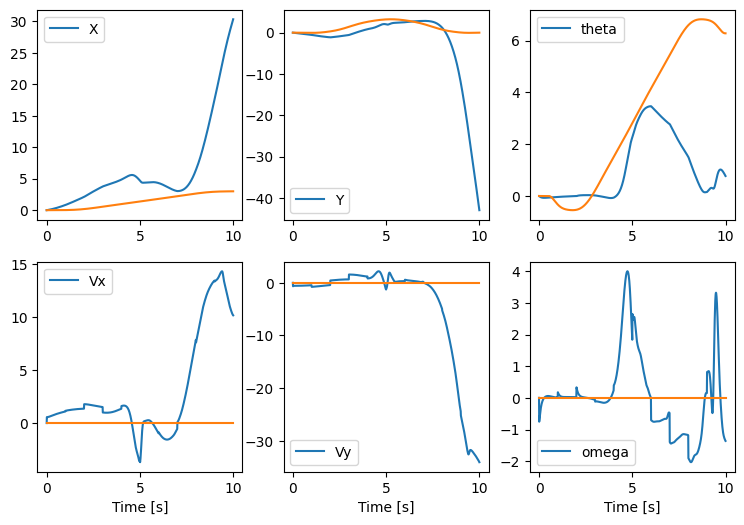

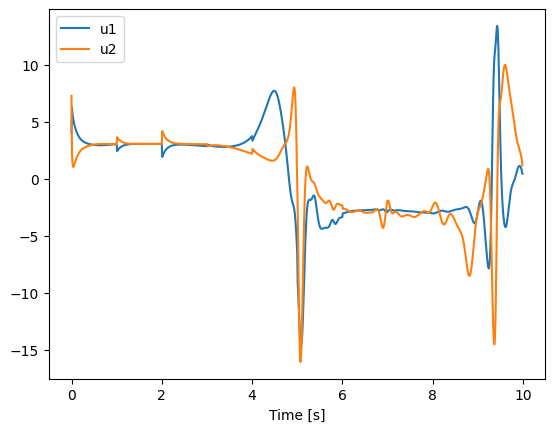

In [9]:
# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.plot(t, state_desired[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_desired[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_desired[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_desired[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_desired[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_desired[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')



In [ ]:
qd.animate_robot(state,u)